# Figure 1 Spectagram
In this notebook we will produce the spectragram shown in Figure 1 in the paper

In [5]:
from Wind_Waves.plotting_tools import attach_corner_label, multi_xlabels, spectragram, mlt_formatter, combine_handles_labels, subplot_align
import numpy as np
start, end= np.datetime64('2004-02-05T18:00'), np.datetime64('2004-02-06T18:00') # set time range

## Figure Setup
Here we setup the figure with subplots, limits, tick parameters etc

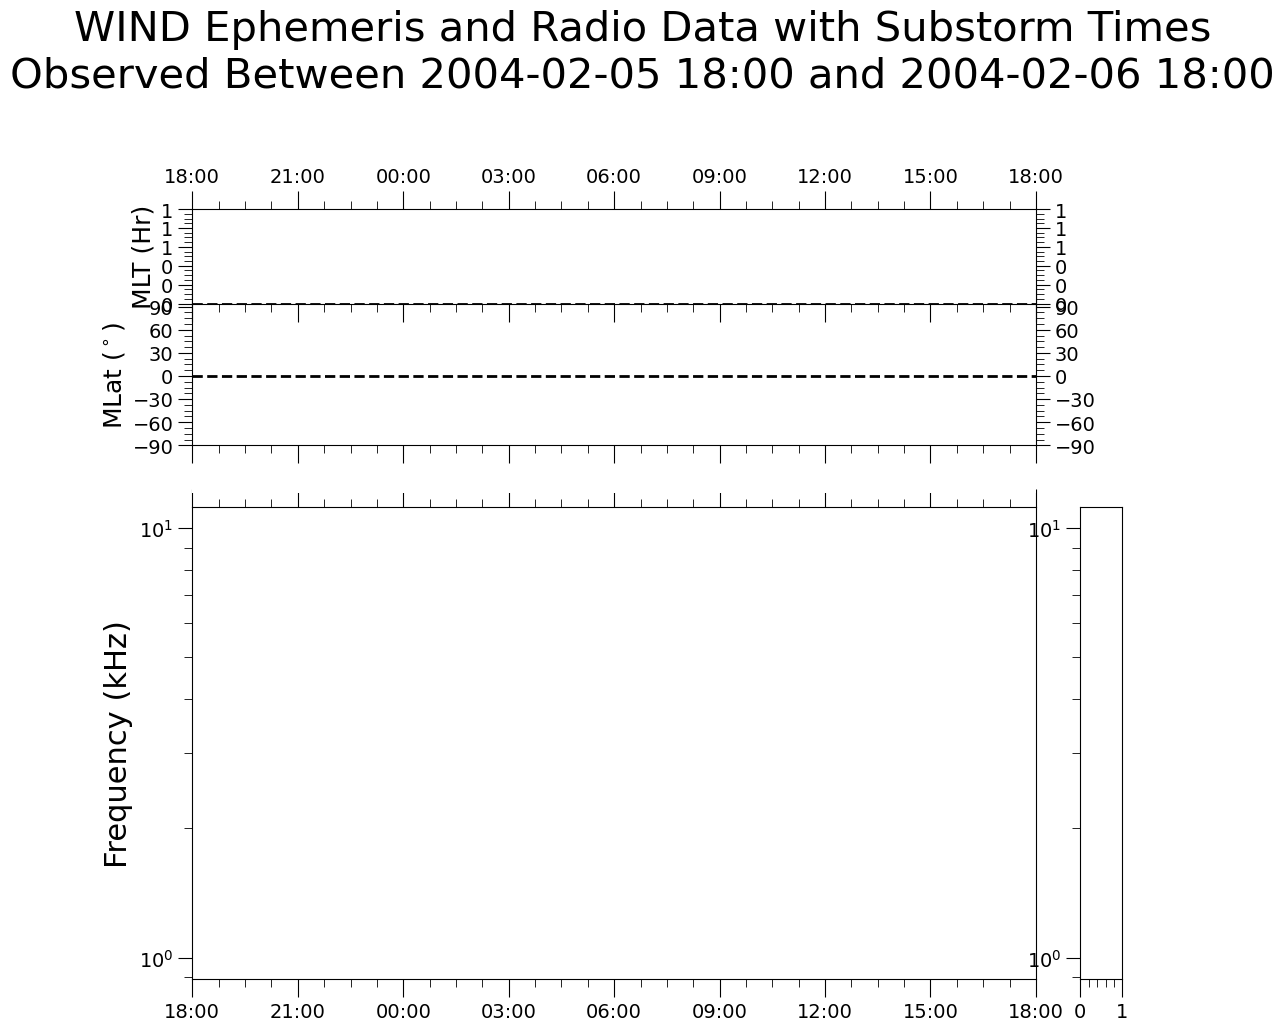

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

fig= plt.figure(figsize=(12, 10))
fig.suptitle(f"WIND Ephemeris and Radio Data with Substorm Times\nObserved Between {start.astype('datetime64[m]').tolist().strftime('%Y-%m-%d %H:%M')} and {end.astype('datetime64[m]').tolist().strftime('%Y-%m-%d %H:%M')}", 
                y=1.08, size=30)
gs= fig.add_gridspec(5, 2, height_ratios=[.2, .3, .1, 0.03, 1], width_ratios=[1, .05], wspace=.1, hspace=0)
spect_ax= fig.add_subplot(gs[-1, 0])
spect_cax= fig.add_subplot(gs[-1, 1])
subt_ax= fig.add_subplot(gs[2, 0])
submlat_ax= fig.add_subplot(gs[1, 0])
submlt_ax= fig.add_subplot(gs[0, 0])
leg_ax= fig.add_subplot(gs[:-1, 1])
leg_ax.axis('off')
spect_ax.set_yscale('log')
spect_cax.set_yscale('log')
for ax in [subt_ax, submlt_ax, submlat_ax, spect_ax, spect_cax]:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='major', size=10, labelsize=14)
    ax.tick_params(axis='x', which='major', size=13, labelsize=14)
    ax.tick_params(axis='both', which='minor', size=6, labelsize=14)
    time_fmt = mdates.DateFormatter('%H:%M')
for ax in [spect_ax, subt_ax, submlt_ax, submlat_ax]:
    ax.xaxis.set_major_formatter(time_fmt)
submlt_ax.yaxis.set_major_formatter(mticker.FuncFormatter(mlt_formatter))
submlat_ax.set_ylim(-90, 94)
submlat_ax.set_yticks(np.arange(-90, 91, 30))
submlat_ax.set_ylabel('MLat ($^\circ$)', size=18)
submlt_ax.set_ylabel('MLT (Hr)', size=18)
spect_ax.set_ylabel('Frequency (kHz)', size=22)
submlt_ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
submlt_ax.tick_params(axis='y', labelleft=True, labelright=True, left=True, right=True, which='both')
submlt_ax.tick_params(labeltop=True, labelbottom=False, bottom=True, top=True,
                        which='both')
submlat_ax.tick_params(axis='y', labelleft=True, labelright=True, left=True, right=True, which='both')
submlat_ax.tick_params(axis='x', labeltop=False, labelbottom=False, bottom=True, top=True, which='both')

spect_ax.tick_params(axis='x', labelbottom=True, bottom=True, top=True, labeltop=False, which='both')
subt_ax.yaxis.set_visible(False)
subt_ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
for ax in [subt_ax]:
    ax.xaxis.set_visible(False)
submlat_ax.spines[['top']].set_visible(False)
for ax in [submlat_ax, submlt_ax]:
    ax.axhline(0, color='black', lw=2, ls='--')
for ax in [spect_ax, submlt_ax, submlat_ax]:
    ax.set_xlim(start, end)

## Adding WIND Ephemeris
- We first load the akr frequency limits obtained in the Data_Download.ipynb notebook and subset it to our time range.
- We then load the WIND location data obtained in the Data_Download.ipynb.
- We then use simple interpolation to calculate the WIND location at any datetime
- We then provide the interpolation functions to multi_xlabels by making them an attribute of spect_ax. These will then be used by matplotlib when calculating the values at every x tick location and allow multiple values to appear on the xticks.
- Finally use attach_corner_label to place titles for the WIND ephemeris ticks to the left of the left most tick labels.

/home/simon/gits/Wind_Waves/src/Wind_Waves/plotting_tools.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ts)


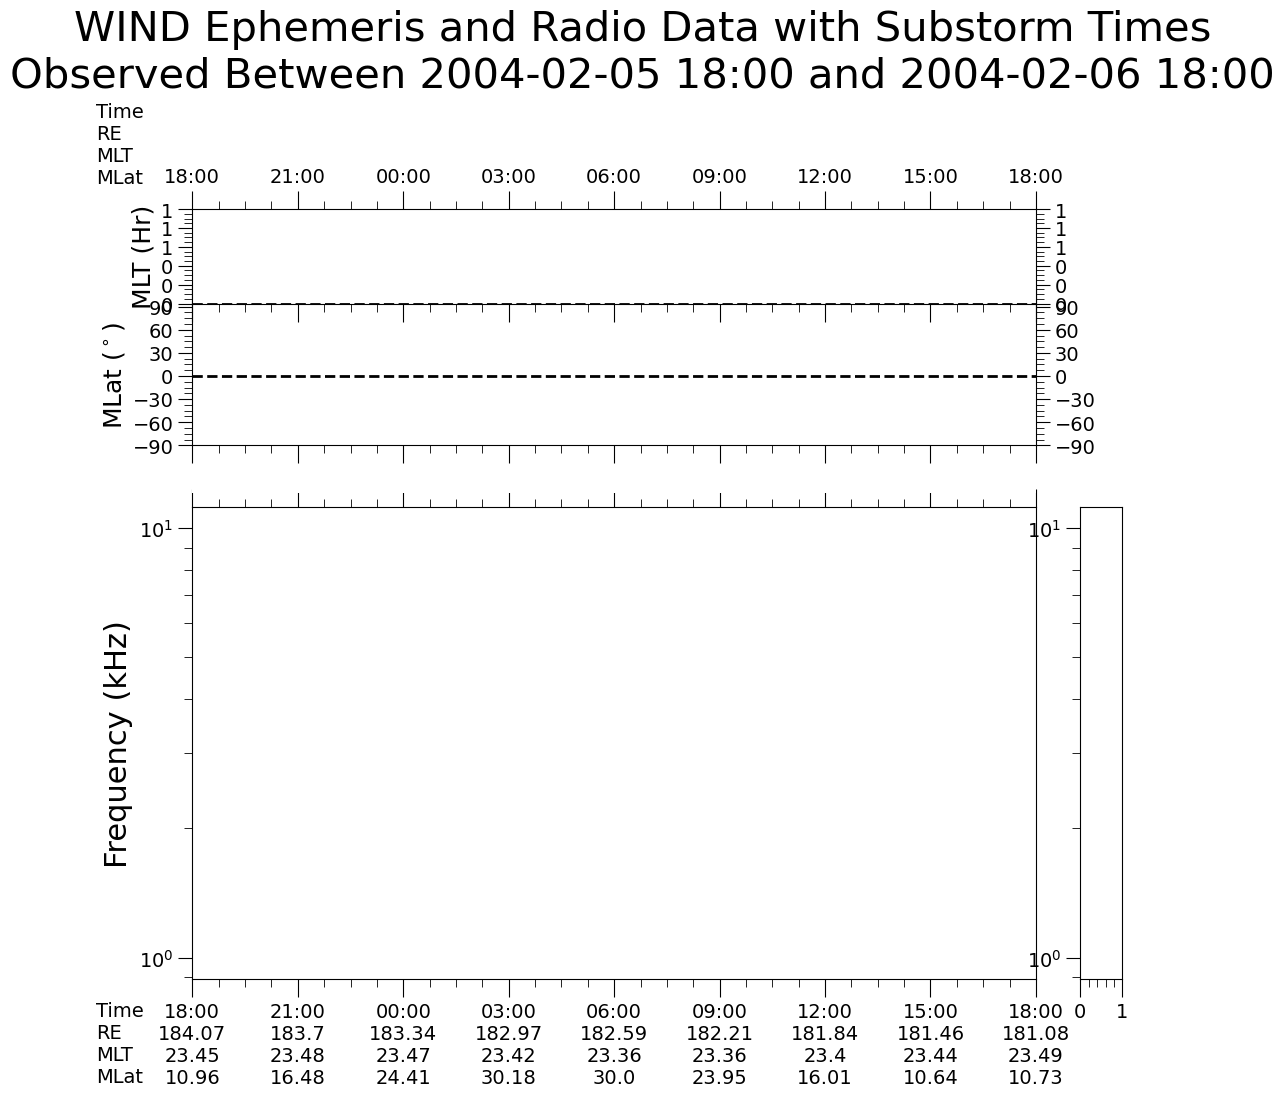

In [7]:
import pandas as pd
from functools import partial
akr_flims= pd.read_csv('../Example_Data/Full_Run_Through/akr_flims_working_version.csv', parse_dates=['Date_UTC'])
akr_flims.sort_values('Date_UTC', inplace=True)
akr_flims= akr_flims.loc[(akr_flims['Date_UTC']>=start)&(akr_flims['Date_UTC']<=end)]

wind_position= pd.read_csv('../Example_Data/Full_Run_Through/WIND_Position_Mag.csv', parse_dates=['Date_UTC'])
def interps(x, *args):
    from scipy.interpolate import interp1d
    return [interp1d(x, arg, fill_value="extrapolate") for arg in args]
position_funcs= interps(mdates.date2num(wind_position['Date_UTC'].values),
                            wind_position.R.values,
                            wind_position.mlt.values,
                            wind_position.mlat.values)

for col, func in zip(['R', 'MLT', 'MLAT'], position_funcs):
    akr_flims[col]= func(mdates.date2num((akr_flims['Date_UTC'].values)))
spect_ax.label_funcs= position_funcs
on_xlim= partial(multi_xlabels, start_strs= ['RE', 'MLT', 'MLat'], keep_original='Time')
spect_ax.callbacks.connect('xlim_changed', on_xlim)
attach_corner_label(spect_ax, fig, 'Time\nRE\nMLT\nMLat', location='below left', offset=(-0.08, 0.022))
attach_corner_label(submlt_ax, fig, 'Time\nRE\nMLT\nMLat', location='above left', offset=(-0.08, 0.022))

multi_xlabels(spect_ax, start_strs=['RE', 'MLT', 'MLat'], keep_original='Time')
fig

## Loading Raw Data
We provide the tools to read WIND dat files. raw2csv will load the raw dat files and convert them into csvs and adds quality flags.
We use vaex for handling the csv files but pandas could be used as well as they are basic csv files. If the csvs have already been made then the conversion is skipped.

- We recalculate the sweep column so that it covers both days of files as current sweep numbering is done for each day
- We also calculate the spin number. We do not use it in this example but the notebook high_resolution_spectragram.ipynb showcases the advantages of averaging over spins rather than sweeps.

In [8]:
from Wind_Waves.integration_tools import create_sweeps, create_spins
from Wind_Waves.reading_tools import raw2csv
import vaex as vx
days = start+ np.arange((end.astype('datetime64[D]')-start.astype('datetime64[D]')).astype('timedelta64[D]')+1)
raw= vx.open(list((np.unique([raw2csv(date, '../Example_Data/raw_rad1/', '../Example_Data/raw_rad1/') for date in (days)]))))
raw.drop('SWEEP', inplace=True)
raw= raw.to_pandas_df()
create_sweeps(raw, time='Date_UTC')
create_spins(raw, spin='SPIN')
raw= vx.from_pandas(raw)

## Plotting Raw Data
We use the function spectragram to create our spectragram. We provide the raw data as a vaex dataframe. If a matplotlib subplot is not provided the raw data is returned along with the time and frequency bins with the gap_filling applied and averages over the groupby column. Here we specify fill, this applies linear interpolation in time and then in frequency this provides a smooth spectragram filling missing frequencies and time gaps between sweeps.

- gap_filling can be set to 'ignore' which will plot a common spectragram where gaps in frequency are ignored and it is assumed that the frequency bandwidth is larger than it is and spreads to the midpoint betweeen neighbouring frequency channels.
- gap_filling can be set to 'keep' this will keep time and frequency gaps and demonstrate how the raw data actually looks by using the instrument bandwidth and sweep lenght to plot each pixel

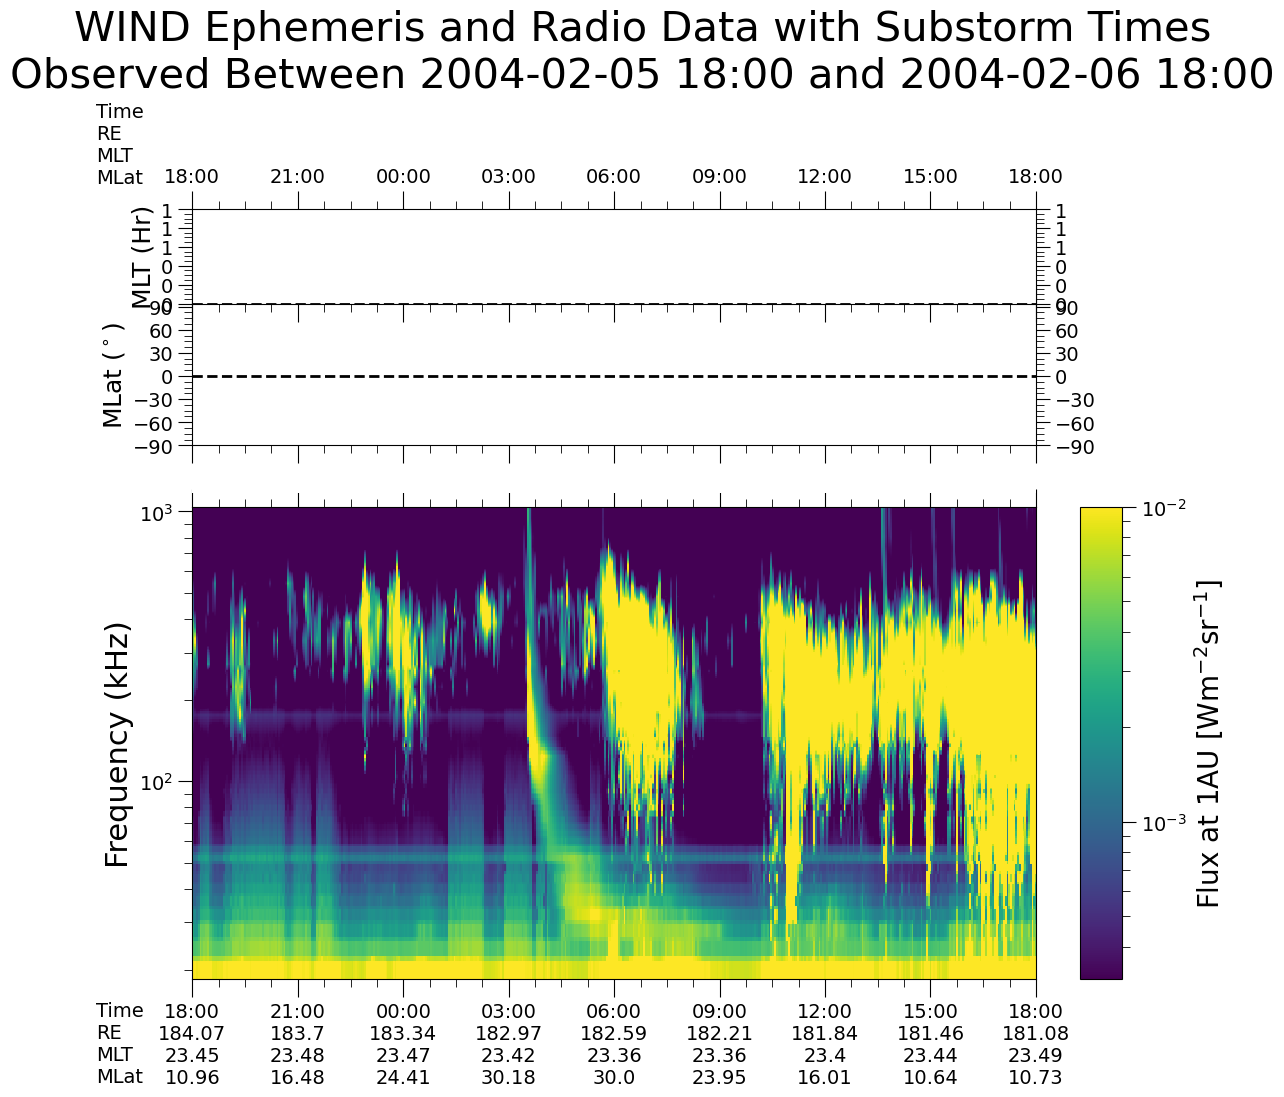

In [9]:
pc, vals= spectragram(raw, ax=spect_ax, groupby='SWEEP', frequency='FREQ', datetime='DATETIME_Z', flux='VZPAL',
                    start=start, end=end, gap_filling='fill')
cbar= fig.colorbar(pc, cax=spect_cax)
cbar.set_label('Flux at 1AU [Wm$^{-2}$sr$^{-1}$]', size=20)
fig

## Adding Substorm Information
Here we add the time and location of the substorm events from each substorm list to the upper three panels

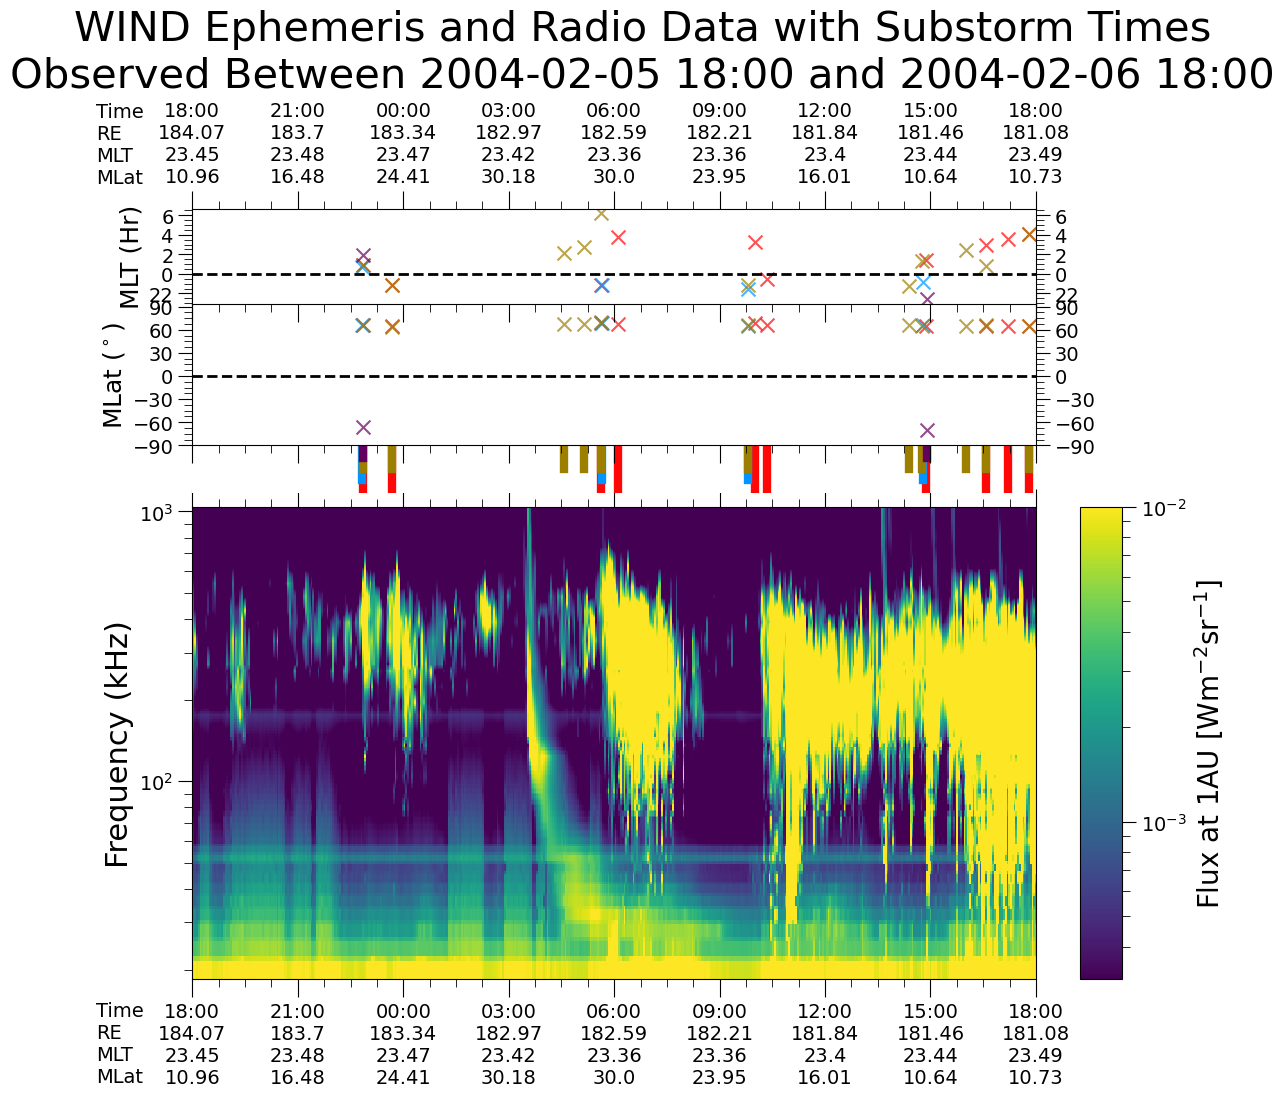

In [10]:
event_names= ['Newell and Gjerloev\n(2011)', 'Ohtani and Gjerloev\n(2020)', 'SOPHIE', 'Combined Imagery']
event_lists= [pd.read_csv(f'../Example_Data/Full_Run_Through/{sub}.csv', parse_dates=['Date_UTC']) for sub in ['newell', 'ohtani', 'sophie', 'combined_imagery']]
event_lists= [df.loc[(df['Date_UTC']>=start)&(df['Date_UTC']<=end)] for df in event_lists]

colors=['#ff0707', '#0095ff', '#9d7f00', '#64005e']
linestyles = ['-'] * len(colors)
linewidths = np.arange(1, len(linestyles)+1)[::-1]
lengths = linewidths * -1.5
linewidths*=2
linewidths= [6]*len(linewidths)

for sub, label, c, ls, lw, l in zip(event_lists,
                                    event_names,
                                    colors, linestyles, linewidths, lengths):
    for i, (date, mlt, mlat) in enumerate(zip(sub['Date_UTC'], sub.MLT, sub.MLAT)):

        if not i:
            subt_ax.plot([date]*2, [0, l], color=c, linestyle=ls, label=label, lw=lw)
        else:
            subt_ax.plot([date]*2, [0, l], color=c, linestyle=ls, lw=lw)
    mlt = sub.MLT.values
    mlt[mlt>12]-=24  # Adjust MLT to be in the range -12 to 12
    submlt_ax.scatter(sub['Date_UTC'], mlt, color=c, s=100, marker='x', alpha=0.7)
    submlat_ax.scatter(sub['Date_UTC'], sub.MLAT, color=c, s=100, marker='x', alpha=0.7)
for ax in [submlat_ax, submlt_ax, subt_ax]:
    ax.sharex(spect_ax)
fig

## Adding AKR Burst Limits
Here we draw on the frequency limits of the AKR burst identified by Fogg 2023

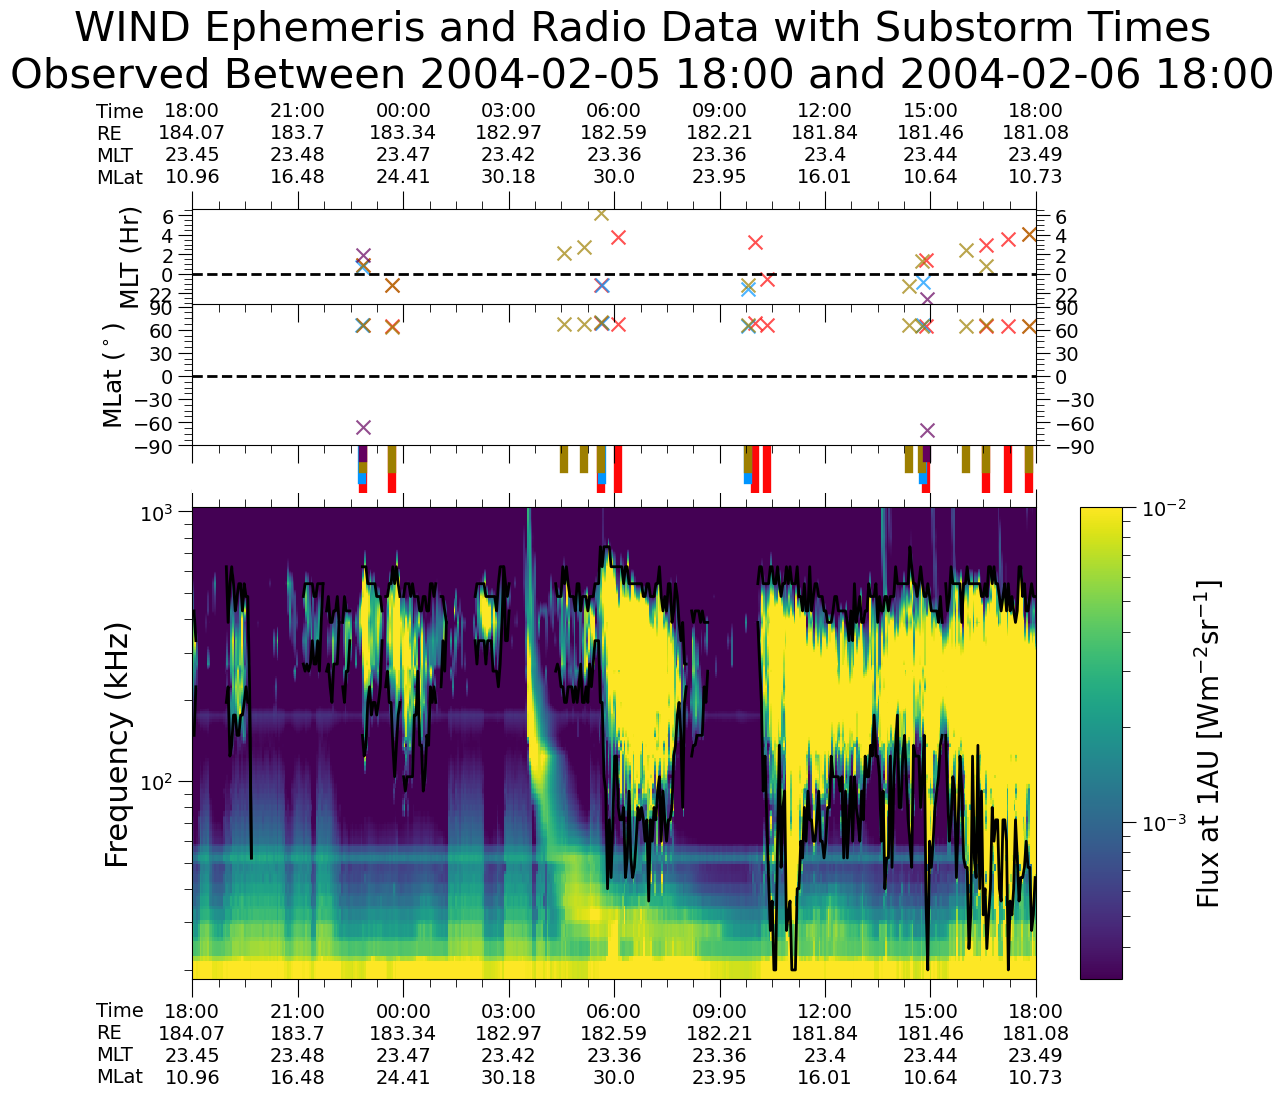

In [11]:
spect_ax.plot(akr_flims['Date_UTC'], akr_flims.fmin, color='black', lw=2, ls='-', label='AKR Burst', zorder=10)
spect_ax.plot(akr_flims['Date_UTC'], akr_flims.fmax, color='black', lw=2, ls='-', zorder=10)
fig

### Adding the Legend
Here we add the legend. Special care is taken to make the legend not only indicate the colour for each substorm list but also its relative length in panel C

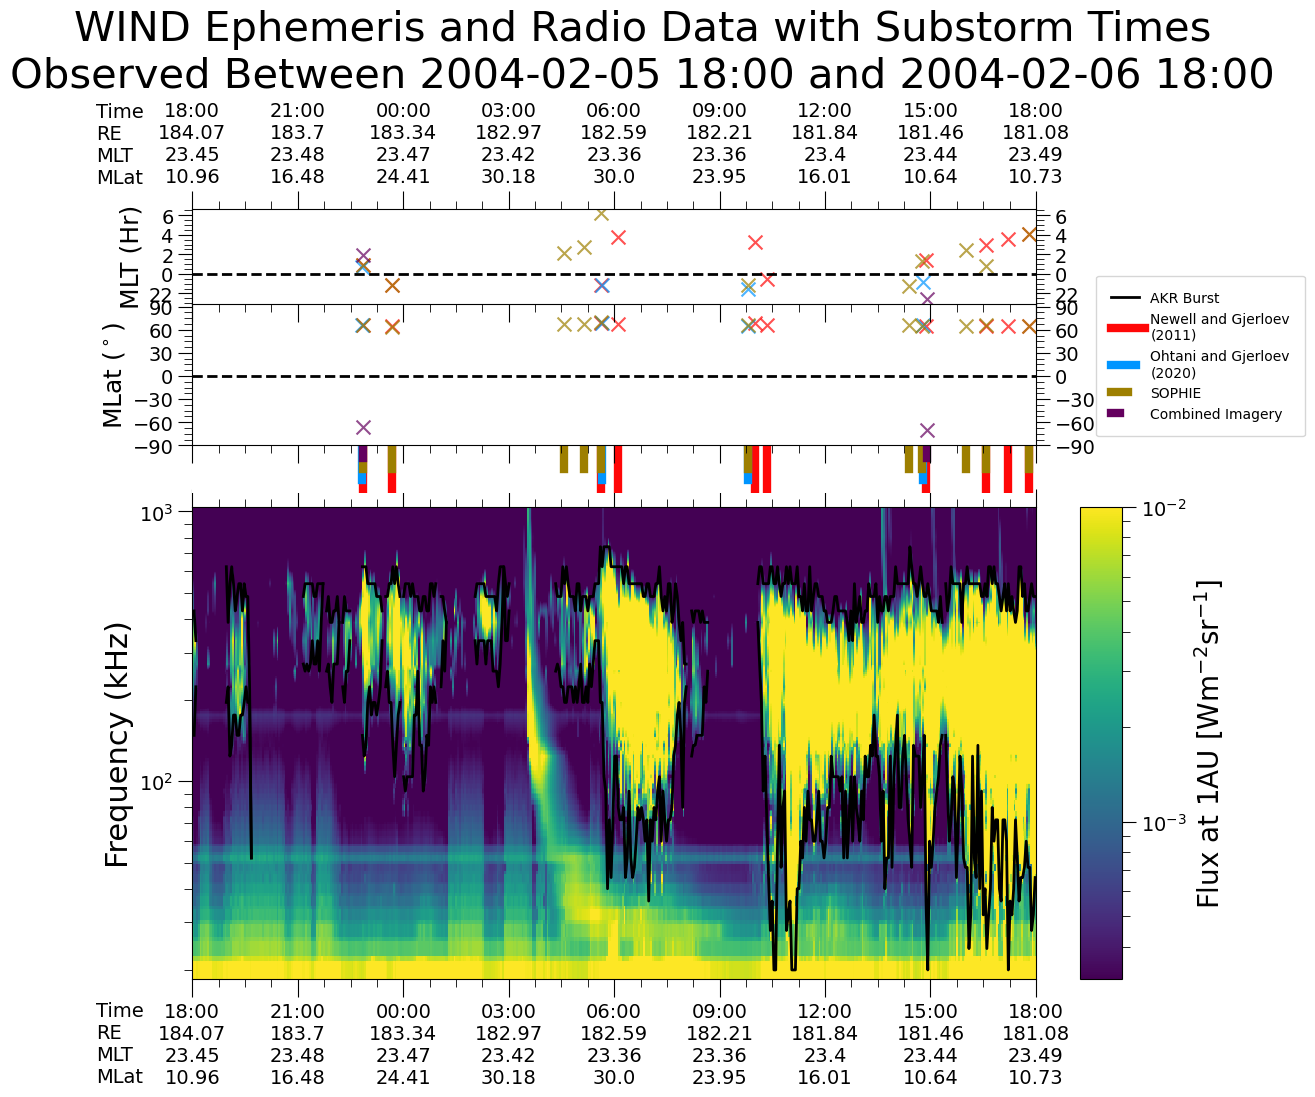

In [12]:
from matplotlib.legend_handler import HandlerLine2D


class ScaledHandler(HandlerLine2D):
    def __init__(self, ratio=1.0, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def create_artists(self, legend, orig_handle,
                        xdescent, ydescent, width, height, fontsize, trans):
        # Scale width by ratio
        new_width = width * self.ratio
        return super().create_artists(
            legend, orig_handle,
            xdescent, ydescent, new_width, height, fontsize, trans
        )
handles, labels= combine_handles_labels(spect_ax, subt_ax)
handler_map = {}
mapper = dict(zip(labels, handles))

for label in labels:
    if label not in event_names:
        h= mapper[label]
        handler_map[h] = ScaledHandler(ratio=1)
for l, event_name in zip(lengths, event_names):
    h= mapper[event_name]
    handler_map[h] = ScaledHandler(ratio=l*-.2)
leg_ax.legend(handles, labels, handler_map=handler_map, bbox_to_anchor=(5.5, .8), borderpad=1.1)
fig

### Adding Subplot Labels
Here we add the text to label the subplots for easy reference

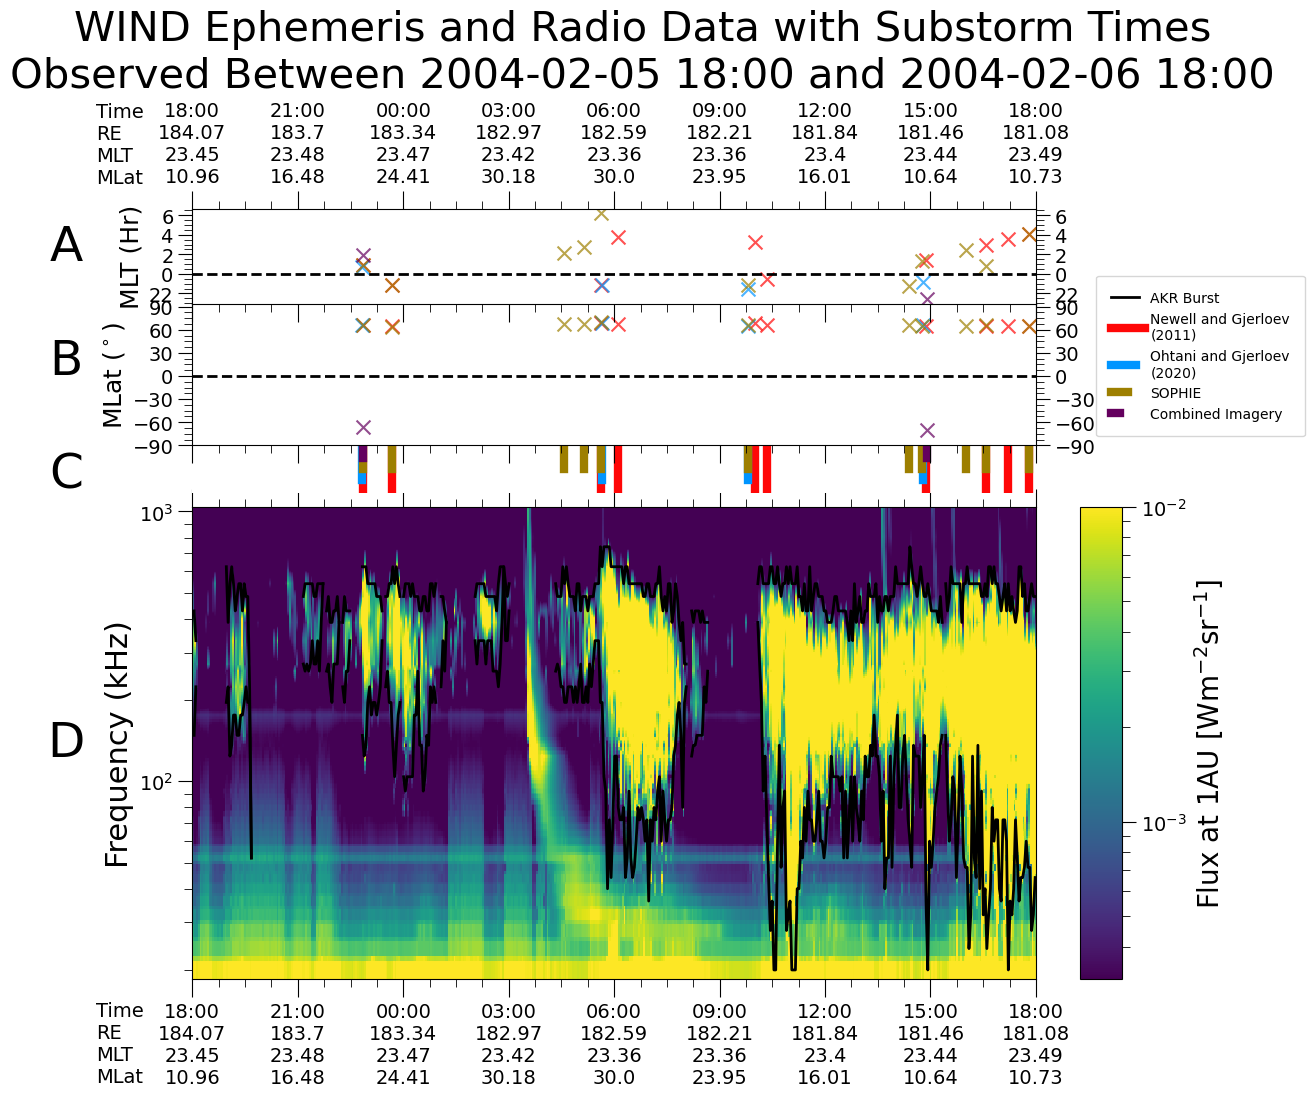

In [13]:
ts=[]
for i, ax in enumerate([submlat_ax, submlt_ax][::-1]):
    ts.append(ax.text(-0.15, .6, f'{chr(65+i)}', transform=ax.transAxes, ha='center', va='center', fontsize=35))
ts.append(subt_ax.text(-0.15, .38, f'{chr(65+2)}', transform=subt_ax.transAxes, ha='center', va='center', fontsize=35))
ts.append(spect_ax.text(-0.15, .5, f'{chr(65+3)}', transform=spect_ax.transAxes, ha='center', va='center', fontsize=35,
                        color='black'))
fig

### Add Ellipses
Just as in the paper we add ellipses to highlight the two combined imagery onsets that we discuss in the paper and label them 1 and 2

/home/simon/gits/Wind_Waves/src/Wind_Waves/plotting_tools.py:212: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ts)


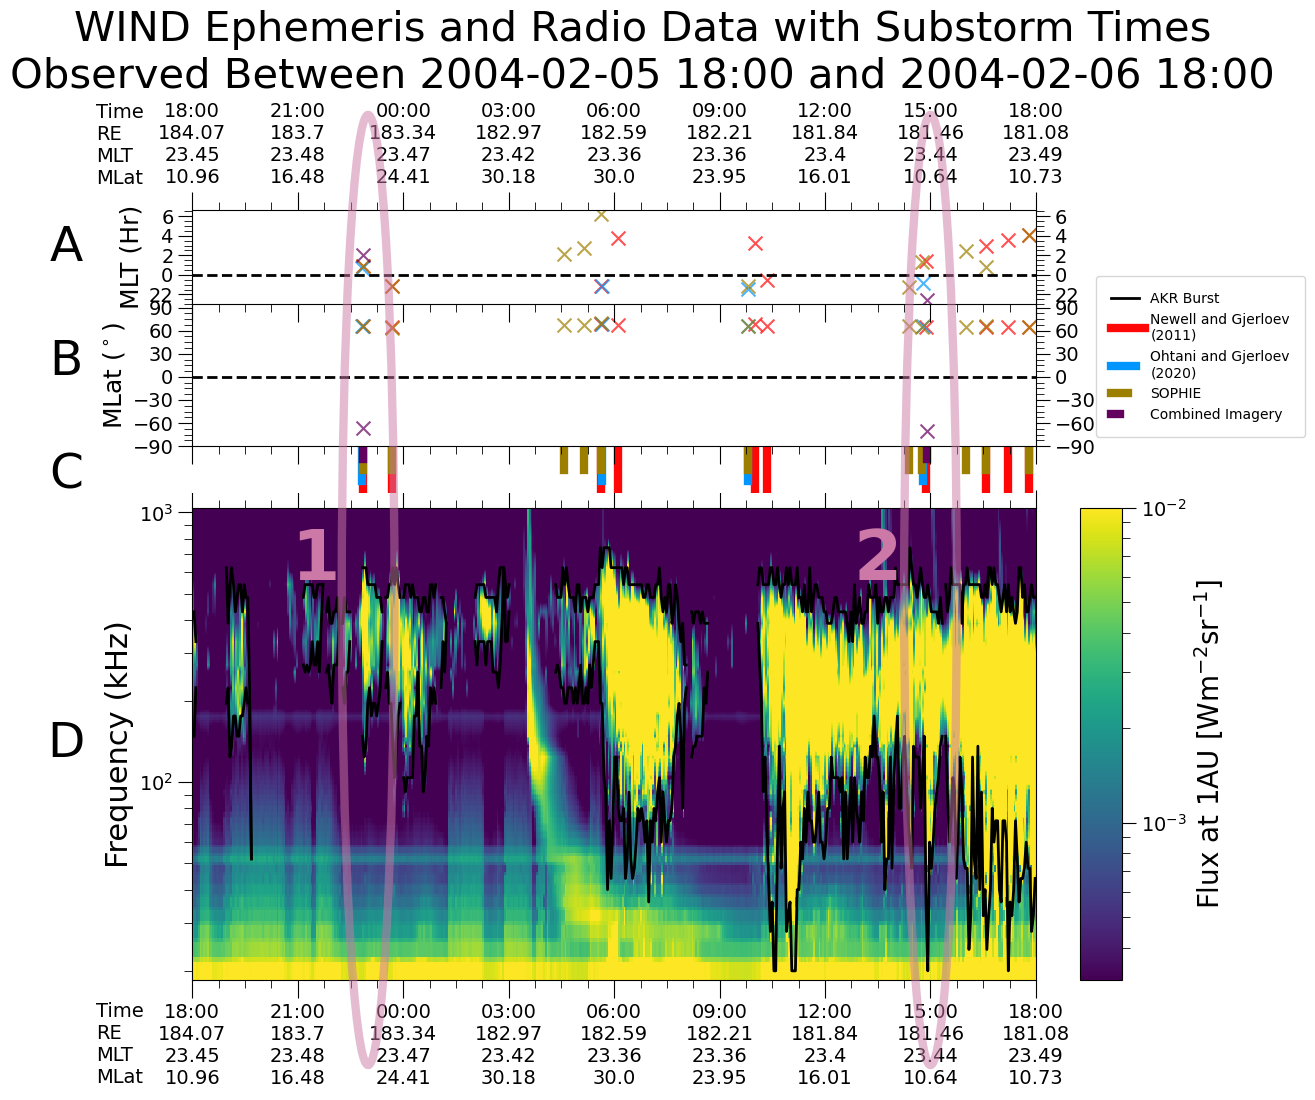

In [14]:
import matplotlib.patches as mpatches

# Create a new axes that covers the whole figure and shares x/y with main_ax
ellipse_ax = fig.add_subplot(111, sharex=spect_ax)
pos= spect_ax.get_position()
ellipse_ax.set_position([pos.x0, 0, pos.width, 1])
# ellipse_ax.set_facecolor('none')  # Transparent background

# Hide ticks and labels
ellipse_ax.axis('off')

# Ellipse parameters
center_time = mdates.date2num(pd.Timestamp('2004-02-05 23:00'))
center_freq = .5  # Set to desired frequency (y) value
width = mdates.date2num(pd.Timestamp('2004-02-05 23:30')) - mdates.date2num(pd.Timestamp('2004-02-05 22:00'))  # Width in days
height = .95  # In log10(kHz) or kHz, adjust as needed   

ellipse = mpatches.Ellipse(
    (center_time, center_freq),
    width=width,  # Convert days to seconds
    height=height,
    edgecolor='#CC79A7',
    facecolor='none',
    lw=6,
    zorder=11,
    alpha=0.5
)
# Add label "A" at the center of the ellipse
t= ellipse_ax.text(
    center_time*.999995, .53, "1",
    color='#CC79A7', fontsize=50, weight='bold', ha='center', va='center',
    zorder=12)

patch= ellipse_ax.add_patch(ellipse)

# Ellipse parameters
center_time = mdates.date2num(pd.Timestamp('2004-02-06 15:00'))
center_freq = .5  # Set to desired frequency (y) value
width = mdates.date2num(pd.Timestamp('2004-02-05 23:30')) - mdates.date2num(pd.Timestamp('2004-02-05 22:00'))  # Width in days
height = .95  # In log10(kHz) or kHz, adjust as needed   
ellipse_ax.set_ylim(0, 1)
ellipse = mpatches.Ellipse(
    (center_time, center_freq),
    width=width,  # Convert days to seconds
    height=height,
    edgecolor='#CC79A7',
    facecolor='none',
    lw=6,
    zorder=11,
    alpha=0.5
)
# Add label "A" at the center of the ellipse
t= ellipse_ax.text(
    center_time*.999995, .53, "2",
    color='#CC79A7', fontsize=50, weight='bold', ha='center', va='center',
    zorder=12)

patch= ellipse_ax.add_patch(ellipse)

subplot_align(ellipse_ax, spect_ax, dim='x')
ellipse_ax.set_xlim(start, end)
fig